# Scaling Greenhouse Gases through a Small Watershed
Load and plot greenhouse gas (GHG) data from the LRHO watershed.

For each site, this script will load in the sensor discharge data, along with fDOM (and etc),
and plot the cumulative discharge and variable for each year.

Parameters
----------
info

subfolder

LMPghg_input

QUESTghg_input

grab_input

Created on Thu Oct 16 14:21:08 2025

@author: etipps


# Introduction
In many global carbon budgets, rivers are still considered as 'pipelines' that passively transport carbon from land to ocean, but more recent studies show that a significant fraction of that carbon is outgassed to the atmosphere. However, there is still a lot of variation between study sites and regions. Understanding what drives greenhouse gas production in our rivers and streams is an important step towards quantifying how much of those gases may be entering the atmosphere.

# Research question and hypotheses
Are surface-water greenhouse gas concentrations more biologically or hydrologically driven and how may that change scaling up a watershed?

# Study site
I will be looking at 6 sites along the Lamprey River
LMP07 and SMB are tributaries in the upper watershed, NBR and NCB-down are located in the middle watershed, LMP 27 is in the lower portion of the watershed and LMP 72 is the outlet. There are USGS gages located near LMP 27 and LMP 72.
[I'll add more information here about the watershed characteristics of the Lamprey and include a map of the sites and gages]

# Data sets
Greenhouse gas data collected as grab samples from each site across one year
Daily discharge data from each USGS gage

In [1]:
# Imports
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import matplotlib.cm as cm

In [2]:
# Parameters
info = 'sites.txt'

subfolder = Path('Data')

LMPghg_input = '251014 EPSCoR Gas Query.xlsx'

QUESTghg_input = '251014 QuEST Lamprey Data with GHG.xlsx'

grab_input = '20251001 Lamprey Weekly Monthly QAQC w formatting.xlsx'

Q_lower = 'usgs_newmarket.txt'

Q_upper = 'usgs_raymond.txt'

In [3]:
# Generate site list
with open(info, "r") as sitenames:
	sites = sitenames.readlines()
    
sites = sites[0]
sites=sites.split(',')

In [4]:
# Function to read in data
def wrangle(datafile, sites):
    """"
    Read in excel file of Lamprey data, set collection date as index and remove measurements without GHG
    data
    
    Parameters
    ----------
    datafile : string
        Name of filename to be read in
        
    Returns
    ---------
    data : DataFrame
        Wrangled data frame
    """
    
    filename = subfolder/datafile

    data = pd.read_excel(filename,
                           parse_dates=['Collection Date'], index_col='Collection Date')
    
    # Remove sites that aren't in site list
    data = data[data['Sample Name'].isin(sites)]
    
    # Loop through columns to remove rows with GHG data 
    for col in data.columns.tolist():
        if col.startswith('CH4') or col.startswith('CO2') or col.startswith('N2O'):
            data.dropna(subset = col, inplace = True)
    
    # sort df by index
    data.sort_index(inplace=True)
    
    return data


In [5]:
# Wrangle input data
quest_data = wrangle(QUESTghg_input, sites)

LMP_data = wrangle(LMPghg_input, sites)

grab_data = wrangle(grab_input, sites)  

# splice LMP_data to have the same start time as quest
start = quest_data.index[0]
LMP_data = LMP_data[start:]   

In [6]:
# Import and wrangle discharge data
upper_q = pd.read_csv(subfolder/Q_upper, delimiter = '\t', comment = '#', header = 1,
                     parse_dates=['20d'], index_col=['20d'])

lower_q = pd.read_csv(subfolder/Q_lower, delimiter = '\t', comment = '#', header = 1,
                     parse_dates=['20d'], index_col=['20d'])

# Rename discharge columns and drop irrelevant columns
upper_q.rename(columns = {"14n":"Q_CFS"}, inplace = True)
upper_q.index.names = ['DATE']

lower_q.rename(columns = {"14n":"Q_CFS"}, inplace = True)
lower_q.index.names = ['DATE']


/var/folders/86/3vj2gl_x4cg1shtp3zdz7nvm0000gn/T/ipykernel_34994/894936873.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(sites))


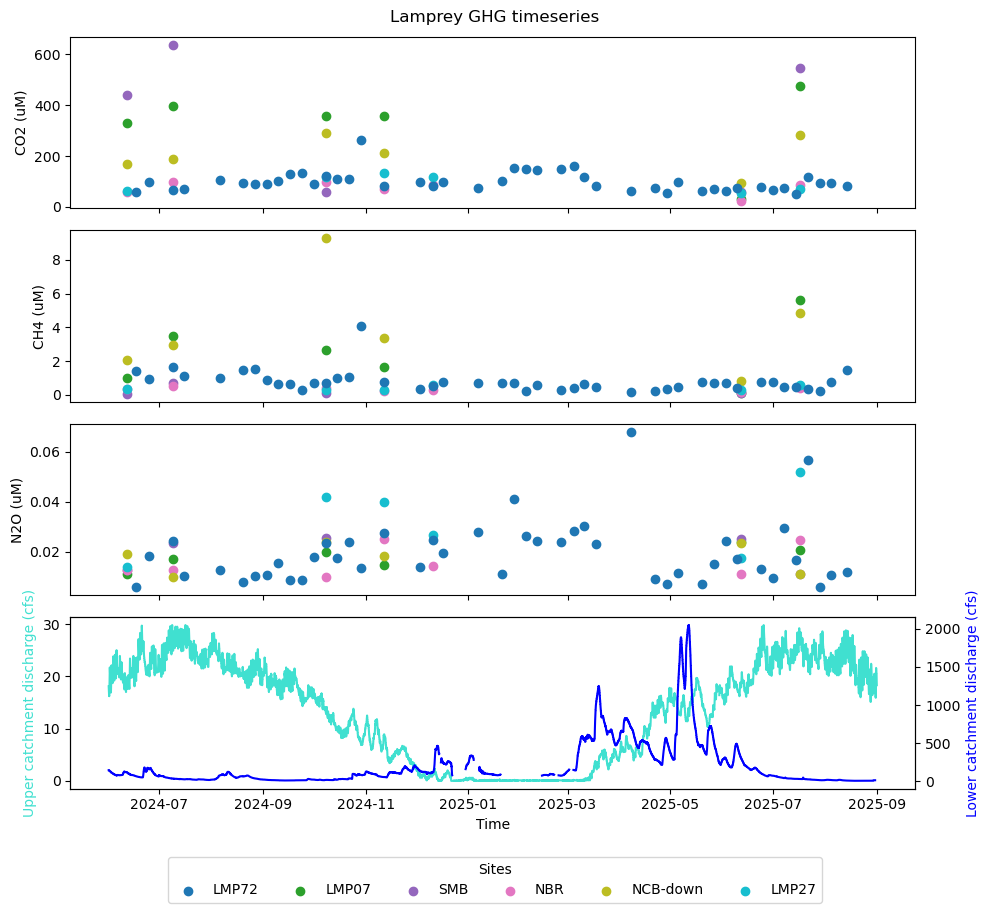

In [7]:
# Initial timeseries plot
colors = cm.get_cmap('tab10', len(sites))
fig_title = 'Lamprey GHG timeseries'
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (10,9), sharex = True)
fig.suptitle(fig_title)

# Plot 1: CO2 from each site
for idx, site in enumerate(sites):
    site_data = quest_data[quest_data['Sample Name'] == site]
    ax1.scatter(site_data.index, site_data['CO2_uM'],
                label=site, color=colors(idx))

for idx, site in enumerate(sites):
    site_data = LMP_data[LMP_data['Sample Name'] == site]
    ax1.scatter(site_data.index, site_data['CO2_umol_L'],
                label=None, color=colors(idx))

ax1.set_ylabel('CO2 (uM)')

# Plot 2: CH4 from each site
for idx, site in enumerate(sites):
    site_data = quest_data[quest_data['Sample Name'] == site]
    ax2.scatter(site_data.index, site_data['CH4_uM'],
                label=site, color=colors(idx))

for idx, site in enumerate(sites):
    site_data = LMP_data[LMP_data['Sample Name'] == site]
    ax2.scatter(site_data.index, site_data['CH4_umol_L'],
                label=None, color=colors(idx))

ax2.set_ylabel('CH4 (uM)')

# Plot 3: N2O from each site
for idx, site in enumerate(sites):
    site_data = quest_data[quest_data['Sample Name'] == site]
    ax3.scatter(site_data.index, site_data['N2O_uM'],
                label=site, color=colors(idx))

for idx, site in enumerate(sites):
    site_data = LMP_data[LMP_data['Sample Name'] == site]
    ax3.scatter(site_data.index, site_data['N2O_umol_L'],
                label=None, color=colors(idx))

ax3.set_ylabel('N2O (uM)')

# Plot 4: Discharge timeseries
ax5 = ax4.twinx()
ax4.plot(upper_q["Q_CFS"], color = "turquoise")
ax5.plot(lower_q["Q_CFS"], color = "blue")

ax4.set_ylabel('Upper catchment discharge (cfs)', color = "turquoise")
ax5.set_ylabel('Lower catchment discharge (cfs)', color = "blue")

ax4.set_xlabel('Time')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels,
           loc='lower center', ncol=len(sites), bbox_to_anchor=(0.5, -0.02),
           title='Sites')

plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.show()


# CQ slope of GHG along Lamprey watershed
For each site, I will match its greenhouse gas sample with the discharge of the date-time it was collected (lower catchment discharge for LMP 72, upper catchment discharge for all other sites) to visualize and calculate its CQ slope over one year. I will then be able to qualitatively evaluate how that relationship changes when moving up in represented watershed area.

# CQ slope v. CVc/CVq
Building off of the previous analysis, for each site I will plot the CQ slope with the ratio of the coefficient of variance for concentration and discharge. For each site, I will calculate the CV of the GHG concentrations for the year and the CV for its corresponding discharge gage for the year. Plotting the CQ slope with CVc/CVq will indicate if the dynamics of GHG concentrations are more biologically or hydrologically driven.

# GHG with biological indicator
I hypothesize the dynamics of GHG concentrations are more biologically driven, particularly for CH4 and N2O. To test this, I am going to perform a linear regression of each site's greenhouse gas concentration with the ratio of NH4+/NO3-. Each grab sample of greenhouse gas concentrations was also analyzed for NH4+ and NO3- and studies have found that the ratio of these two can indicate redox conditions, which may correlate with greenhouse gas production. 

# Discussion/conclusion
There is not as much data readily available than I had initially thought for this project, with greenhouse gas data for all sites except LMP 72 being very sparse (there are more sample for this past year that just haven't been analyzed yet) and discharge is limited to USGS gages (we are still building out our hydrograph to calculate discharge at each of these sites). 

I think there is still work that I can do with this data, but it may be very limited. Because of that, I have also been working on a another project looking at precipitation and runoff ratios and how representative they are of solute exports. In this project I am looking at CQ of DOC at lamprey river sites and then looking at the residuals of that CQ analysis with precipitation/runoff ratios that take into account increasing antecedent conditions (P at time t/R at time t, P at time t - 1 week/R at time t, P at time t - 2 weeks/R at time t, etc). I am hoping that I can still try my hand at the analyses I had in mind with the GHG work, but wanted to state that I have a back-up in mind if needed!